At the moment, I'm working towards doing some quasidynamic earthquake rupture and cycle modeling on the South American subduction zone. The fundamental question is how the changes in strike, dip, and overlying topography affect the slip behavior over the full **5,000 km long** subduction zone. I thought it'd be fun to walk through how I made the boundary element mesh for this project.

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

For the fault geometry, I'm using the same triangular subduction zone mesh used by Shannon Graham in her Global Block model papers (LINK?). She built it using the Slab 1.0 contours. I'll load it up and plot it really quickly:

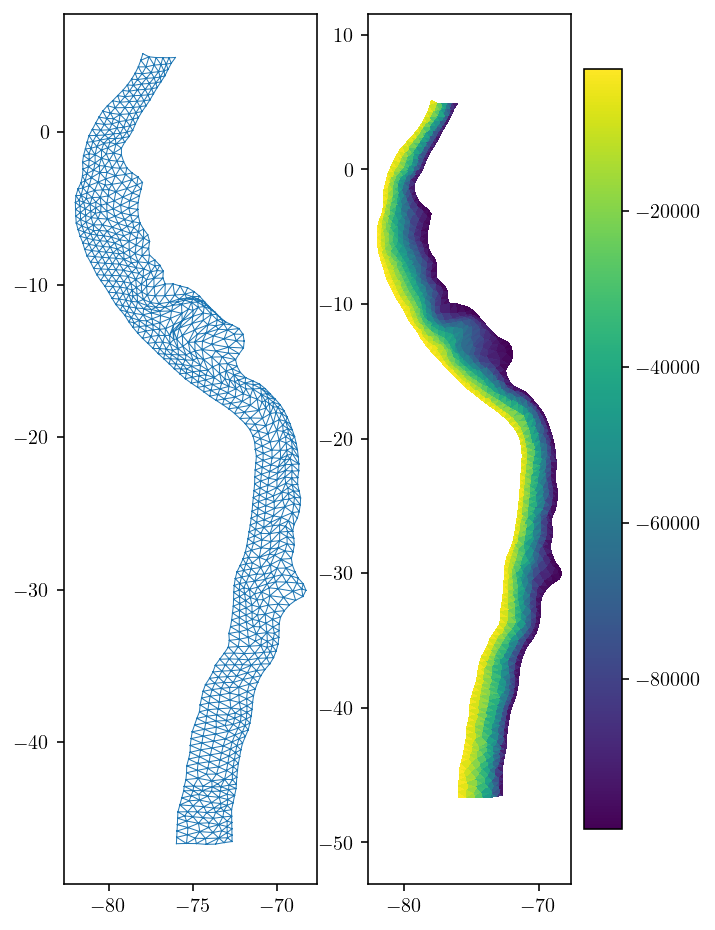

In [2]:
file = scipy.io.loadmat('south_america_50km_mod_ext.mat')
pts = file['c']
pts[:,0] -= 360
pts[:,2] *= 1000
tris = file['v'] - 1
fault_m = (pts, tris)

plt.figure(figsize = (5, 8))
plt.subplot(1,2,1)
plt.triplot(pts[:,0], pts[:,1], tris, linewidth=0.5)
plt.subplot(1,2,2)
tripc = plt.tripcolor(pts[:,0], pts[:,1], tris, pts[:, 2], linewidth=0.5)
plt.colorbar()
plt.xlim([np.min(pts[:,0]), np.max(pts[:,0])])
plt.axis('equal')
plt.show()

Okay. So, we're done right? Nope, we want to add topography and Earth curvature. Why? Because, we can! And because we're interested in the influence of realistic geometry. Also, we need to project to geocentric coordinates -- (X, Y, Z) = (0, 0, 0) is the center of the Earth. 

While writing the [topography paper](http://tbenthompson.com/project/topography/), I found I was downloading a lot of DEM data and found the normal method of downloading a bunch of files from the USGS to be very manual, annoying, and time consuming. So, I start using Mapzen's terrain tile service. Mapzen is (was?) a website/startup that provided a lot of simple tools for mapping. One of these services was an API (free!) for downloading "terrain tiles". You specify an area of the world and a zoom level and they return a geotiff containing the DEM data. This led to some nice automatic meshing scripts for the topography paper. In particular, I could send someone the code with almost no accompanying data and they would be able to run all the analysis. Hurray! 

The trouble is that Mapzen has gone out of business. Bummer! So, I had to find another place to get my DEM data. And I still didn't want to go back to the dark ages of downloading everything manually. So, I tried one of Mapzen's competitor, Mapbox. With a bit of modifications to my meshing code, it worked well. However, I immediately realized a big problem -- the entire ocean was set to zero meters elevations. That's a big problem for me because in for elastic earthquake modelling, the Earth's rocky surface is the relevant surface. The water does not behave elastically. 

So, I was sad and forlorn and had no easy source of DEM data... Until I discovered that Mapzen had [exported their entire terrain tiles dataset to Amazon S3!](https://aws.amazon.com/public-datasets/terrain/). And I had spent several days recently learning the ins and outs of using the Python AWS library, `boto3`. So, I was back in business and in fact, I only needed to make very minor changes. I replaced the old:

``` python
def download_file(x, y, z, save_path):
    tile_url = 'https://tile.mapzen.com/mapzen/terrain/v1/geotiff/{z}/{x}/{y}.tif?api_key={k}'
    filled_url = tile_url.format(z=z, x=x, y=y, k=api_key)
    response = urllib.request.urlopen(filled_url)
    if response.getcode() != 200:
        raise RuntimeError('No such tile: {}'.format((z, x, y)))
    with open(save_path, 'wb') as file:
        file.write(response.read())

```

with the new S3 API calls:

``` python
def download_file(x, y, z, save_path):
    BUCKET_NAME = 'elevation-tiles-prod'
    KEY = 'geotiff/{z}/{x}/{y}.tif'.format(x = x, y = y, z = z)

    s3 = boto3.resource('s3')

    try:
        bucket = s3.Bucket(BUCKET_NAME)
        bucket.download_file(KEY, save_path)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise
```

Let's load up the module that does the DEM collection.

In [3]:
import collect_dem

n_dem_interp_pts = 100
zoom = 2

bounds = collect_dem.get_dem_bounds(fault_m[0])
dem_lon, dem_lat, dem = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)

downloading dem data for bounds = [-51.875283536, -83.3826, 10.333847175999999, -66.93539999999999] and zoom = 2
10.333847175999999 -83.3826
-51.875283536 -66.93539999999999


Combining 2 into dem_download/raw_merc.tif ...


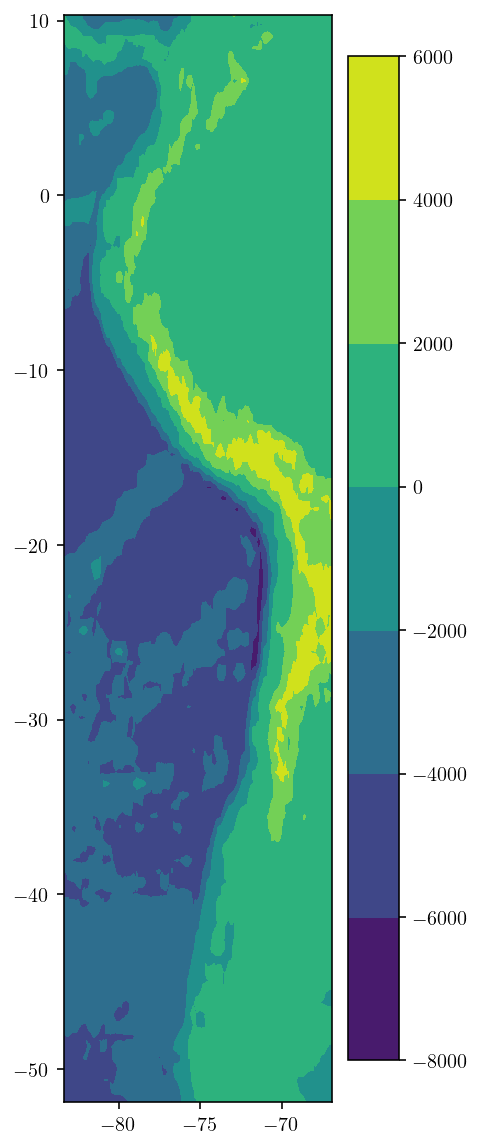

In [4]:
plt.figure(figsize = (3, 10))
plt.tricontourf(dem_lon, dem_lat, dem)
plt.colorbar()
plt.show()

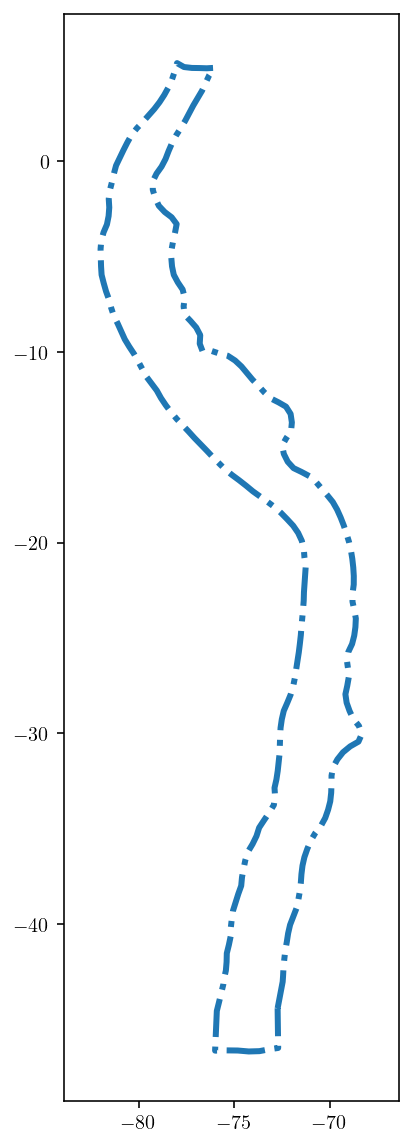

In [5]:
import mesh_fncs
boundary_loops = mesh_fncs.get_boundary_loop(fault_m)
for i in range(len(boundary_loops)):
    L = boundary_loops[i]
    plt.figure(figsize = (3,10))
    plt.plot(fault_m[0][L, 0], fault_m[0][L, 1], '-.')
    plt.axis('equal')
    plt.show()

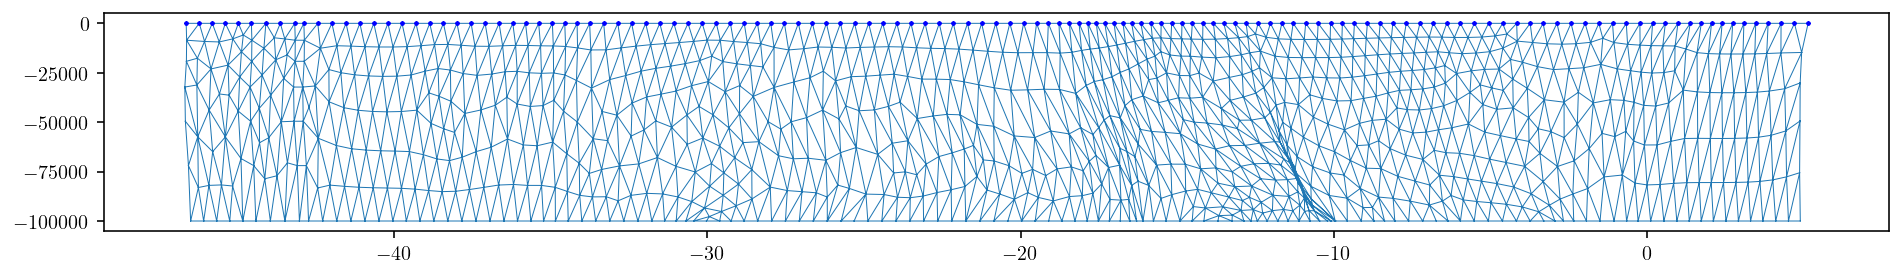

In [127]:
plt.figure(figsize = (16, 2.0))
upper_edge_idxs = boundary_loops[0][130:258]
upper_edge_pts = fault_m[0][upper_edge_idxs,:]
upper_edge_pts.shape
plt.plot(fault_m[0][upper_edge_idxs, 1], fault_m[0][upper_edge_idxs, 2], 'b*', markersize = 2)
plt.triplot(fault_m[0][:,1], fault_m[0][:,2], fault_m[1], linewidth=0.5)
plt.show()

In [108]:
surf_center = np.mean(upper_edge_pts, axis = 0)
fault_L = np.max(np.sqrt(np.sum((upper_edge_pts - surf_center) ** 2, axis = 1)))
mesh_size = fault_L / 12
surf_center, fault_L

(array([-76.1856875 , -20.20007063,   0.        ]), 26.448552746401248)

In [109]:
import pygmsh

In [110]:
30000 ** 2 * 8 / 1e9

7.2

In [111]:
geom = pygmsh.built_in.Geometry()
w = fault_L * 1.5
surf_corners = np.array([
    [surf_center[0] - w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] - w, 0],
    [surf_center[0] + w, surf_center[1] + w, 0],
    [surf_center[0] - w, surf_center[1] + w, 0],
])
surf = geom.add_polygon(surf_corners, mesh_size)

gmsh_pts = dict()
gmsh_pts[0] = geom.add_point(upper_edge_pts[0], mesh_size)
for i in range(1, upper_edge_pts.shape[0]):
    gmsh_pts[i] = geom.add_point(upper_edge_pts[i], mesh_size)
    line = geom.add_line(gmsh_pts[i-1], gmsh_pts[i])
    intersection_code = 'Line{{{}}} In Surface{{{}}};'.format(
        line.id, surf.surface.id
    )
    geom.add_raw_code(intersection_code)

mesh = pygmsh.generate_mesh(
    geom, dim = 2
)

Info    : Running 'gmsh -2 /tmp/tmpxxwxj3i_.geo -format msh -bin -o /tmp/tmp9qsma17a.msh' [Gmsh 4.6.0, 1 node, max. 1 thread]
Info    : Started on Fri Apr  2 20:26:06 2021
Info    : Reading '/tmp/tmpxxwxj3i_.geo'...
Info    : Done reading '/tmp/tmpxxwxj3i_.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing

In [106]:
points = mesh.points
cells = mesh.cells_dict
pt_data = mesh.point_data
cell_data = mesh.cell_data
field_data = mesh.field_data

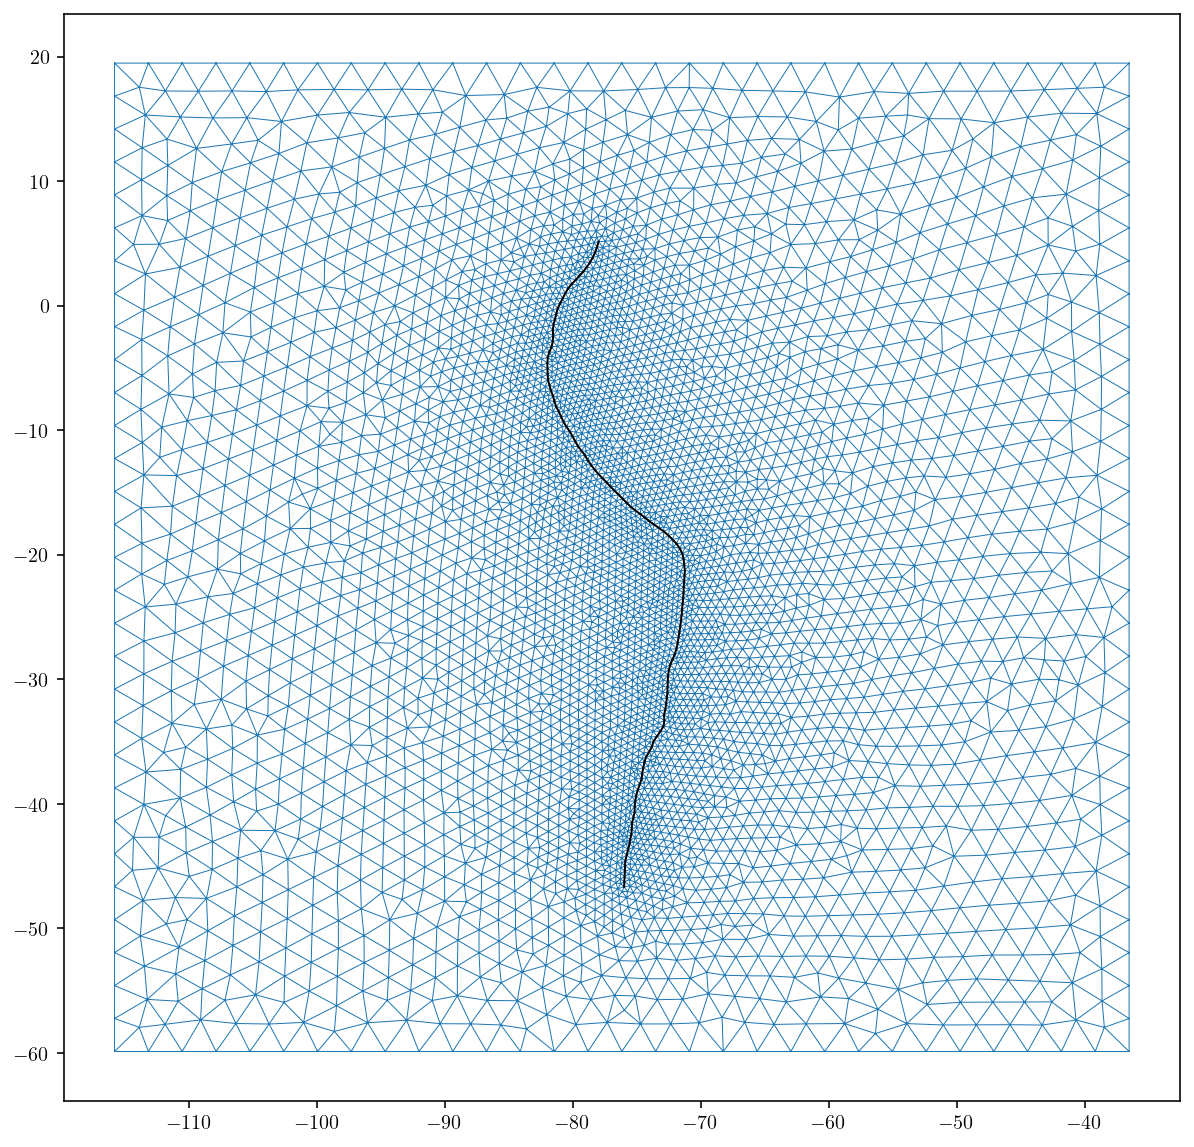

In [113]:
plt.figure(figsize = (10,10))
plt.triplot(points[:,0], points[:,1], cells['triangle'], linewidth = 0.5)
plt.plot(upper_edge_pts[:,0], upper_edge_pts[:,1], 'k-', linewidth = 1.0)#, markersize = 2)
vW = 1.1 * w
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.show()

In [114]:
surf_m = (points, cells['triangle'])

In [115]:
bounds = collect_dem.get_dem_bounds(surf_m[0])
LON, LAT, DEM = collect_dem.get_dem(zoom, bounds, n_dem_interp_pts)

downloading dem data for bounds = [-67.80746557203787, -123.7930824435223, 27.407324315006626, -28.5782925564778] and zoom = 2
27.407324315006626 -123.7930824435223
-67.80746557203787 -28.5782925564778


Combining 6 into dem_download/raw_merc.tif ...


In [161]:
surf_m[0][:,2] = scipy.interpolate.griddata(
    (LON, LAT), DEM, (surf_m[0][:,0], surf_m[0][:,1])
)

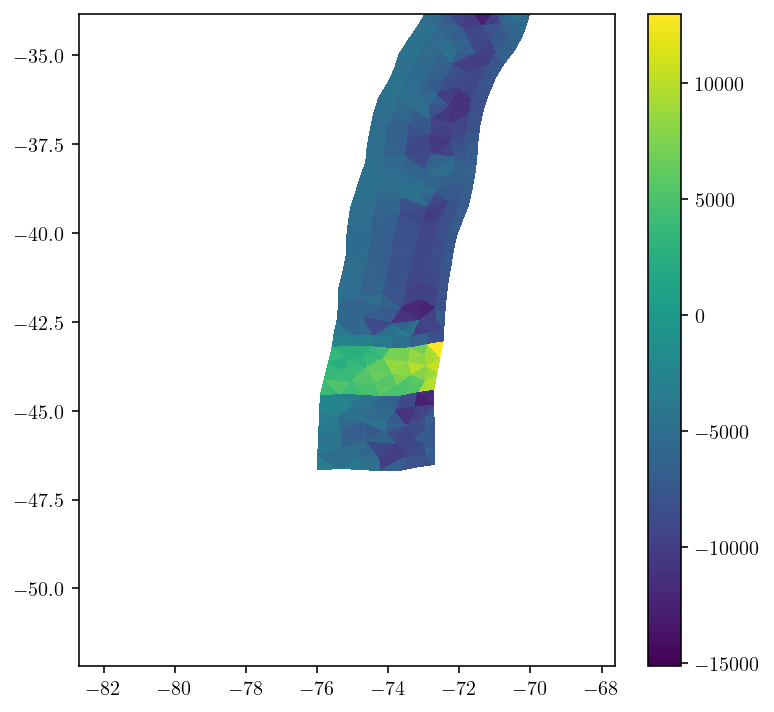

In [162]:
ft = fault_m[0][fault_m[1]]
normals = np.cross(ft[:,1,:] - ft[:,0,:], ft[:,2,:] - ft[:,0,:], axis=1)
plt.figure(figsize = (6, 6))
plt.tripcolor(fault_m[0][:,0], fault_m[0][:,1], fault_m[1], normals[:,0])
plt.colorbar()
plt.axis('equal')
plt.ylim([-46, -40])
plt.show()

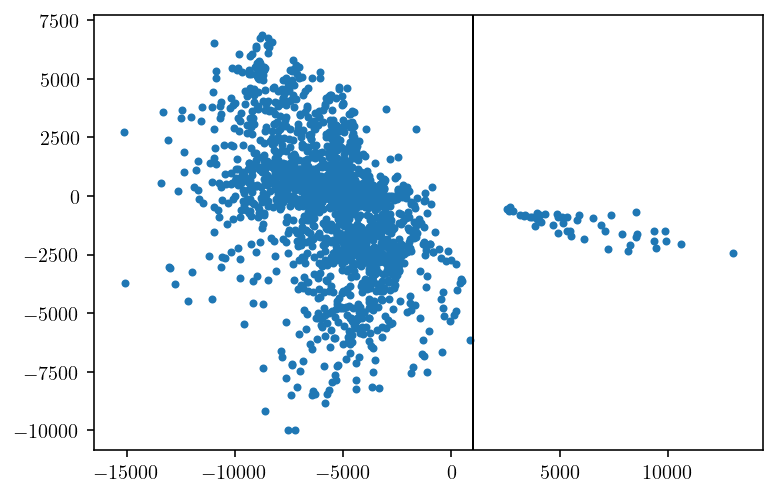

In [163]:
plt.plot(normals[:,0], normals[:, 1], '.')
plt.axvline(1000, color='k', linewidth=1.0)
plt.show()

In [164]:
flip_indices = np.where(normals[:,0] > 1000)

In [165]:
flip_indices

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),)

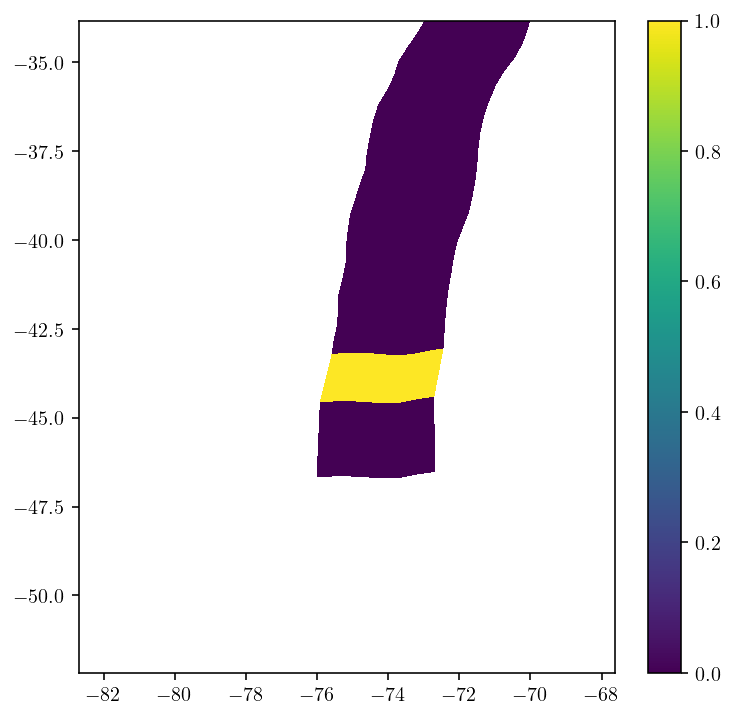

In [177]:
flag = np.zeros_like(normals[:,0])
flag[flip_indices] = 1
ft = fault_m[0][fault_m[1]]
normals = np.cross(ft[:,1,:] - ft[:,0,:], ft[:,2,:] - ft[:,0,:], axis=1)
plt.figure(figsize = (6, 6))
plt.tripcolor(fault_m[0][:,0], fault_m[0][:,1], fault_m[1], flag)
plt.colorbar()
plt.axis('equal')
plt.ylim([-46, -40])
plt.show()

In [179]:
flipped_tris = fault_m[1].copy()
flipped_tris[flip_indices, 1] = fault_m[1][flip_indices,2]
flipped_tris[flip_indices, 2] = fault_m[1][flip_indices,1]

In [180]:
fault_elevation = scipy.interpolate.griddata(
    (LON, LAT), DEM, (fault_m[0][:,0], fault_m[0][:,1])
)

In [181]:
fixed_pts = fault_m[0].copy()
fixed_pts[:,2] += fault_elevation
fixed_fault_m = (fixed_pts, flipped_tris)

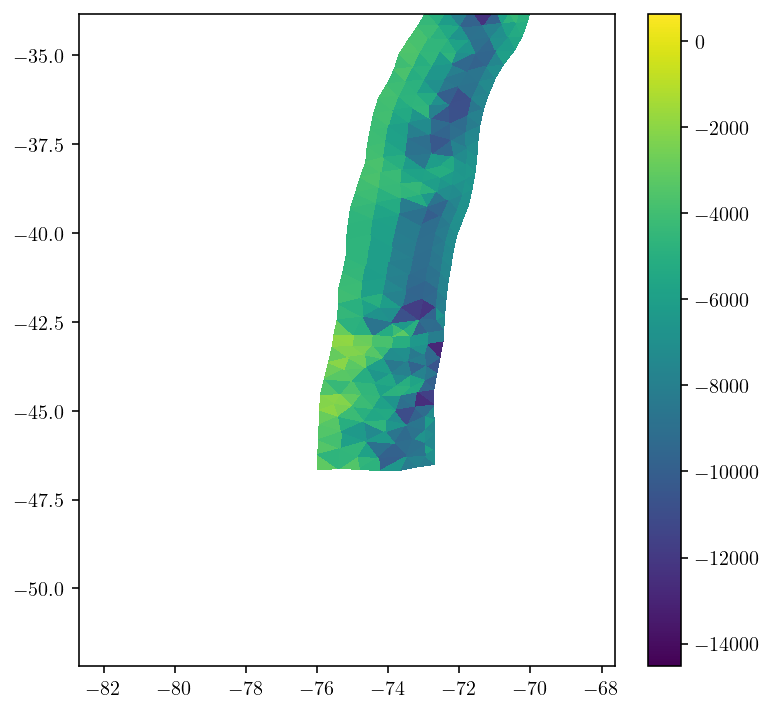

In [182]:
fixed_ft = fixed_fault_m[0][fixed_fault_m[1]]
fixed_normals = np.cross(fixed_ft[:,1,:] - fixed_ft[:,0,:], fixed_ft[:,2,:] - fixed_ft[:,0,:], axis=1)
plt.figure(figsize = (6, 6))
plt.tripcolor(fixed_fault_m[0][:,0], fixed_fault_m[0][:,1], fixed_fault_m[1], fixed_normals[:,0])
plt.colorbar()
plt.axis('equal')
plt.ylim([-46, -40])
plt.show()

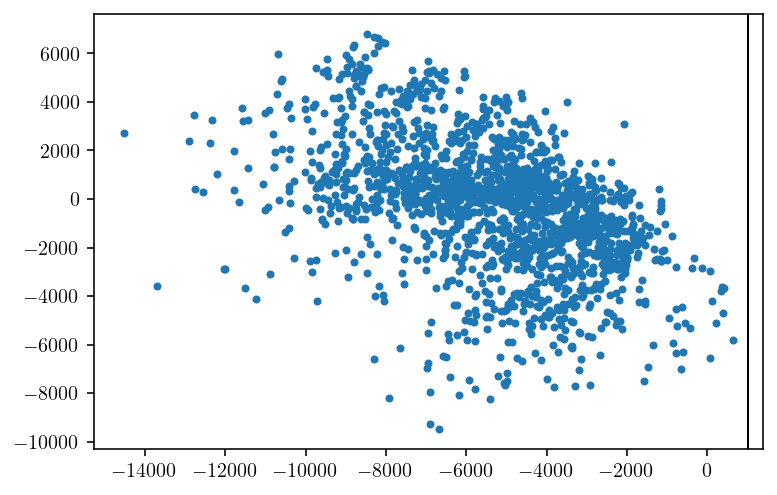

In [183]:
plt.plot(fixed_normals[:,0], fixed_normals[:, 1], '.')
plt.axvline(1000, color='k', linewidth=1.0)
plt.show()

In [184]:
surf_center, vW

(array([-76.1856875 , -20.20007063,   0.        ]), 31.738263295681495)

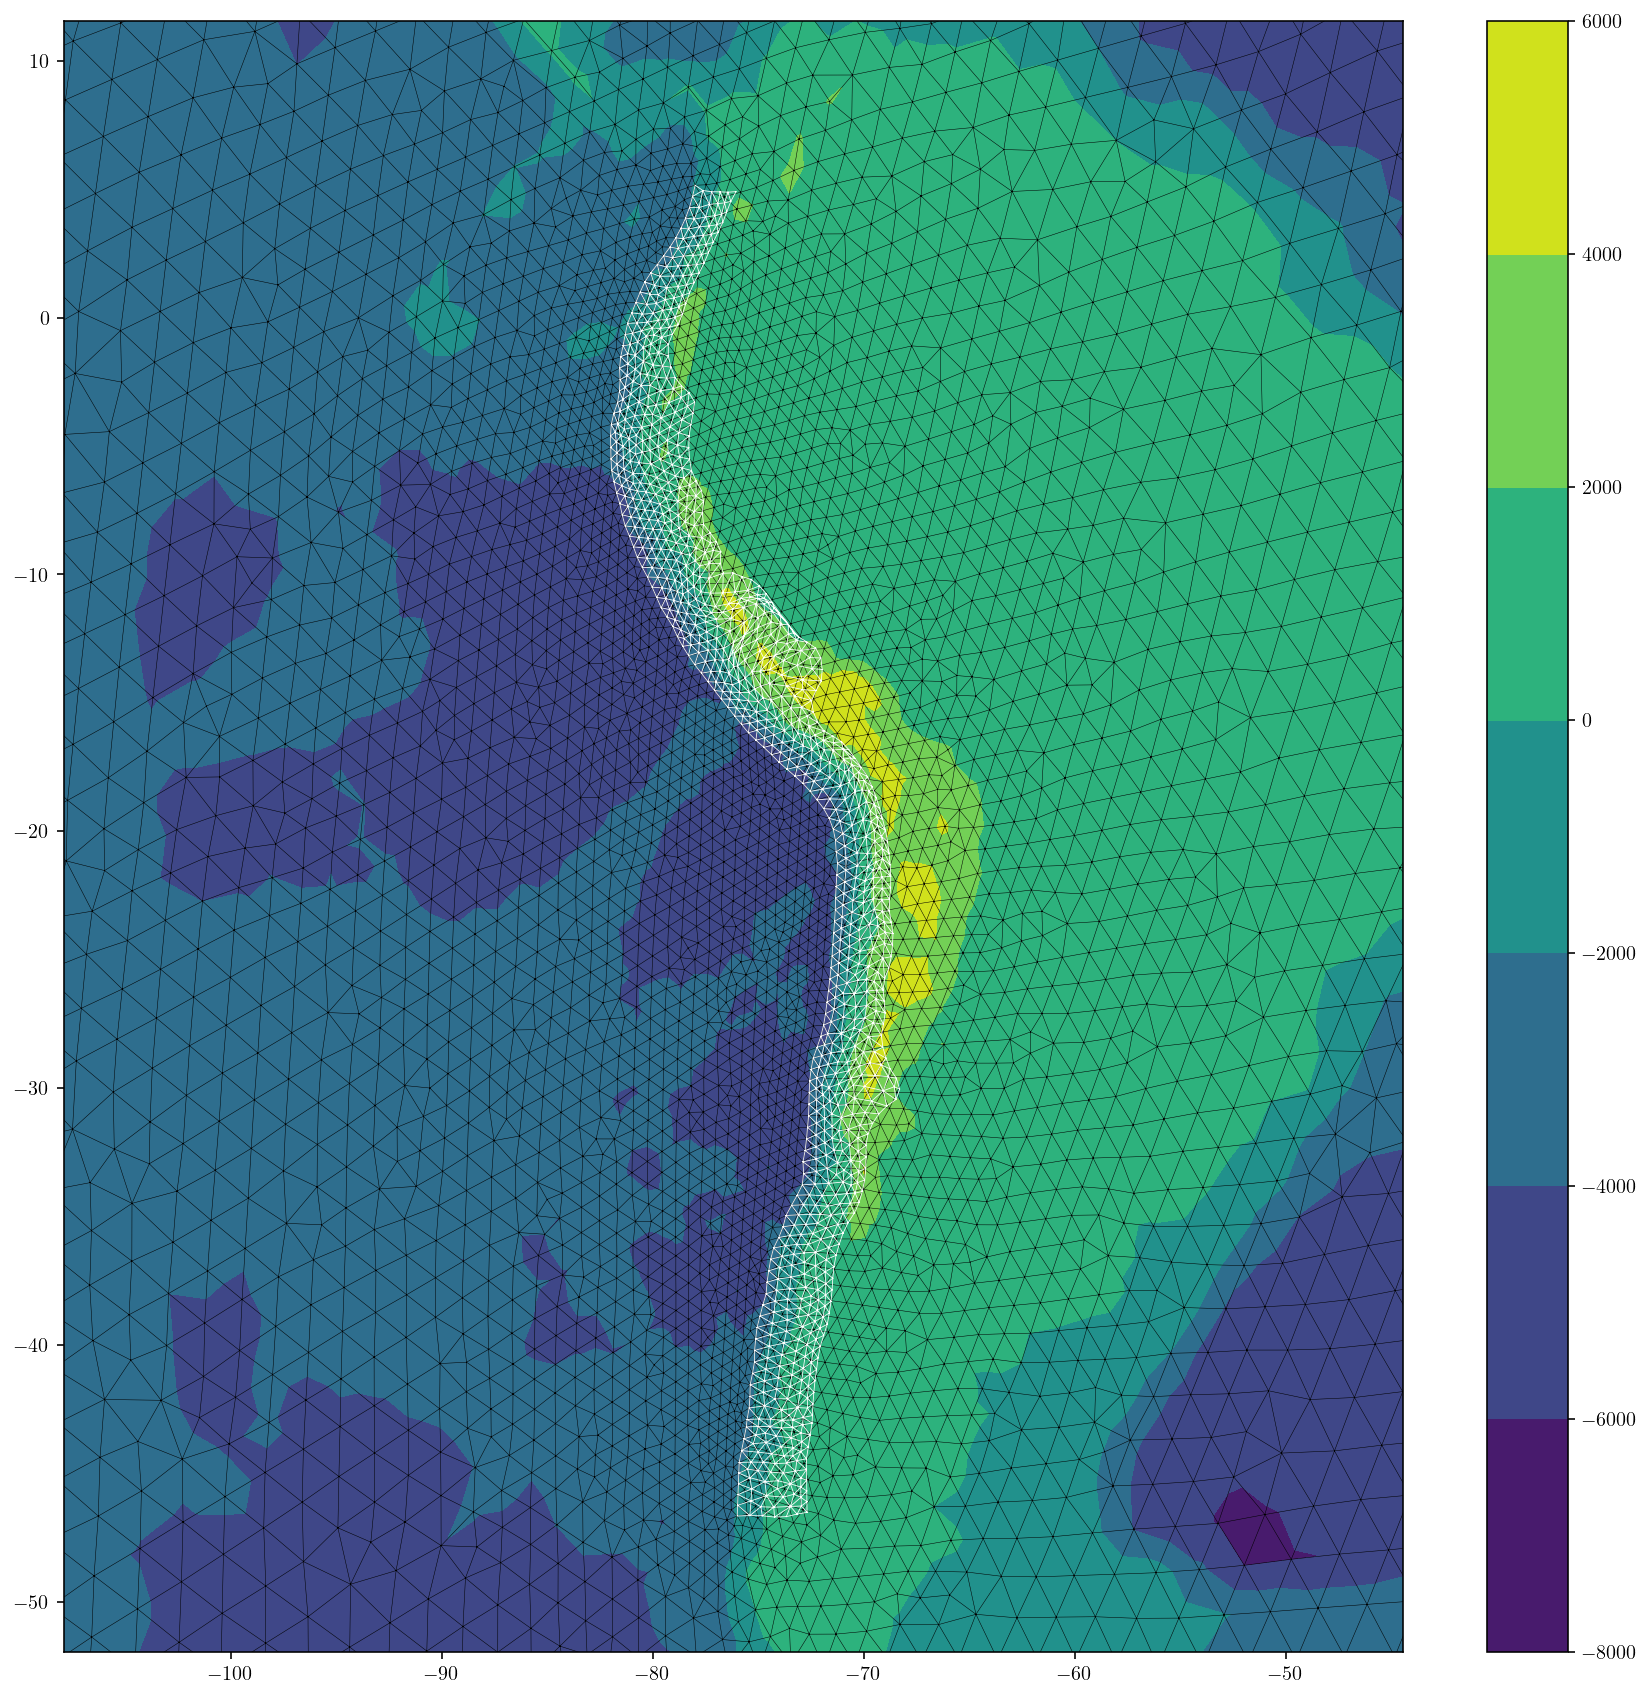

In [185]:
plt.figure(figsize = (15,15))
cntf = plt.tricontourf(surf_m[0][:,0], surf_m[0][:,1], surf_m[1], surf_m[0][:,2])
plt.triplot(surf_m[0][:,0], surf_m[0][:,1], surf_m[1], 'k-', linewidth = 0.25)
plt.triplot(fixed_fault_m[0][:,0], fixed_fault_m[0][:,1], fixed_fault_m[1], 'w-', linewidth = 0.4)
vW = 1.2 * fault_L
plt.xlim([surf_center[0] - vW, surf_center[0] + vW])
plt.ylim([surf_center[1] - vW, surf_center[1] + vW])
plt.colorbar()
plt.savefig('southamericamesh.pdf', bbox_inches = 'tight')
plt.show()

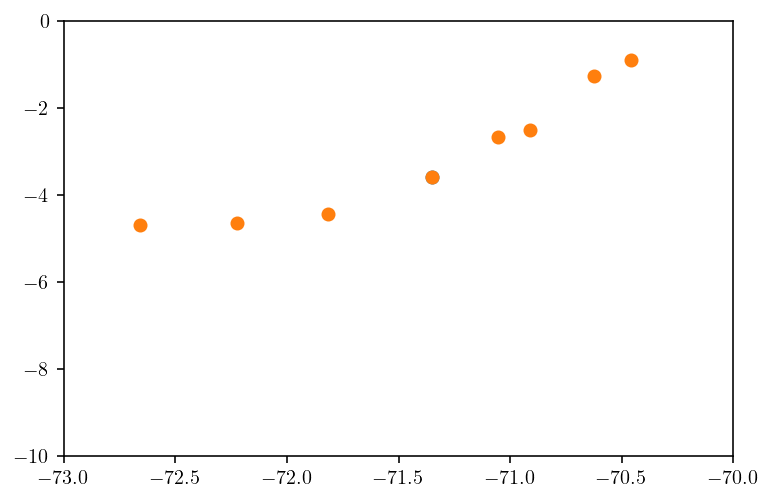

In [186]:
idxs = (fixed_fault_m[0][:,1] < -20) & (fixed_fault_m[0][:,1] > -20.5)
plt.plot(fixed_fault_m[0][idxs,0], fixed_fault_m[0][idxs,2]/1000.0, 'o')
idxs = (surf_m[0][:,1] < -20) & (surf_m[0][:,1] > -20.5)
plt.plot(surf_m[0][idxs,0], surf_m[0][idxs,2]/1000.0, 'o')
plt.xlim([-73, -70])
plt.ylim([-10, 0])
plt.show()

In [187]:
np.save('sa_mesh.npy', np.array([surf_m, fixed_fault_m], dtype=object))